https://www.tensorflow.org/tutorials/keras/classification

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [20]:
def getLabel(_t,fname):
    data = pd.read_csv("dataset/Y/"+ _t +"/"+ fname +".csv")
    _y = []
    _i=0
    
    for i in range(0,301,100):
        x=data["x"][i:i+100]
        y=data["y"][i:i+100]
        
        if _i==0 or _i==2:
             mymodel = np.poly1d(np.polyfit(x,y,2))
        else:
             mymodel = np.poly1d(np.polyfit(y,x,2))
        _i+=1
        _y.append(mymodel.coeffs)
    _y=np.reshape(_y,(-1,12))[0]
    return _y

In [21]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=1) #none color images
  img = tf.image.convert_image_dtype(img, tf.float32) 
   #convert unit8 tensor to floats in the [0,1]range
  return tf.image.resize(img, [224, 224]) 
  #resize the image into 224*224 

In [68]:
from os import walk
import pandas as pd
from sklearn import preprocessing
np.set_printoptions(suppress=True)


train_images = []
train_Y = []
filenames = next(walk("dataset/X/train/"), (None, None, []))[2]  # [] if no file

for fimg in filenames:
  img = tf.io.read_file("dataset/X/train/"+fimg)
  img = decode_img(img)
  train_images.append(img)
  train_Y.append(getLabel("train",fimg.replace(".jpg","")))
train_images = np.array(train_images)

test_images = []
test_Y = []
filenames = next(walk("dataset/X/test/"), (None, None, []))[2]  # [] if no file
for fimg in filenames:
  img = tf.io.read_file("dataset/X/test/"+fimg)
  img = decode_img(img)
  test_images.append(img)
  test_Y.append(getLabel("test",fimg.replace(".jpg","")))
test_images = np.array(test_images)

val_images = []
val_Y = []
filenames = next(walk("dataset/X/val/"), (None, None, []))[2]  # [] if no file
for fimg in filenames:
  img = tf.io.read_file("dataset/X/val/"+fimg)
  img = decode_img(img)
  val_images.append(img)
  val_Y.append(getLabel("val",fimg.replace(".jpg","")))
val_images = np.array(val_images)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

lenTest = len(test_Y)
lenTrain = len(train_Y)
lenVal = len(val_Y)

for i in range(lenTest):
    train_Y.append(test_Y[i])

for i in range(lenVal):
    train_Y.append(val_Y[i])


train_Y = np.array(train_Y)
Y = scaler.fit_transform(train_Y)

train_Y = Y[0:lenTrain]
test_Y = Y[lenTrain:lenTrain+lenTest]
val_Y = Y[lenTrain+lenTest:lenTrain+lenTest+lenVal]


In [69]:
import joblib
joblib.dump(scaler,"scaler3.save")

['scaler3.save']

In [70]:
print("Train Lenght:",lenTrain,train_images.shape)
print("Test Lenght:",lenTest,test_images.shape)
print("Validate Lenght:",lenVal,val_images.shape)

Train Lenght: 1782 (1782, 224, 224, 1)
Test Lenght: 11 (11, 224, 224, 1)
Validate Lenght: 7 (7, 224, 224, 1)


In [25]:
def mdl(model, x):
  B = model
  return (B[0]* x**2) + (B[1] * x) + B[2] 

In [ ]:
import matplotlib.pyplot as plt

for it in range(len(test_Y)):
    pr = []
    __x = scaler.inverse_transform([test_Y[it]])
    for i in range(0,10,3):
      pr.append(__x[0][i:i+3])

    print(pr)
    tempImg = tf.image.resize(test_images[it], [800, 800]) 
    line = np.linspace(0,800,100)
    plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.set_xlim([0,800])
    axes.set_ylim([0,800])
    axes.invert_yaxis()
    #axes.invert_xaxis()
    print(tempImg.shape)
    plt.imshow(np.squeeze(tempImg) ,cmap="gray")
    c = ['r','g','b','y']
    for i in range(4):
      if i==0 or i==2:
        plt.plot(line,mdl(pr[i],line),c=c[i])
      else:
        plt.plot(mdl(pr[i],line),line,c=c[i])

    plt.show()

from tensorflow.keras.layers import Dense,Flatten, LayerNormalization,Conv2D, MaxPool2D 

model = tf.keras.models.Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(units=12,activation=tf.keras.activations.relu))
model.add(LayerNormalization())

In [71]:
from tensorflow.keras.layers import Dense,Flatten ,Dropout 
from tensorflow.keras.layers import Conv2D, MaxPool2D, LayerNormalization

model = tf.keras.models.Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(224, 224,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(4000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(12, activation=tf.keras.layers.LeakyReLU(alpha=0.02)))

model.add(LayerNormalization())
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0001), loss=[tf.keras.metrics.RootMeanSquaredError()])

In [72]:
from tensorflow import keras
rmse = tf.keras.metrics.RootMeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mean_squared_error',
              metrics=[rmse,'mae'])

In [73]:
#train_images = np.array(train_images)
train_images = train_images / 255.0

#test_images = np.array(test_images)
test_images = test_images / 255.0

#test_images = np.array(test_images)
val_images = val_images / 255.0

In [41]:
print(train_images.shape)

(1782, 224, 224, 1)


In [33]:
#Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="newmodel/model_new6.ckpt",save_weights_only=True,verbose=1, save_freq=1000)

In [74]:
hist = model.fit(train_images, train_Y, epochs=9000, verbose=2,validation_data=(val_images,val_Y))#,callbacks=cp_callback)

Epoch 1/9000
56/56 - 5s - loss: 0.2577 - root_mean_squared_error: 0.5076 - mae: 0.4970 - val_loss: 0.2497 - val_root_mean_squared_error: 0.4997 - val_mae: 0.4908
Epoch 2/9000
56/56 - 5s - loss: 0.2431 - root_mean_squared_error: 0.4931 - mae: 0.4903 - val_loss: 0.2439 - val_root_mean_squared_error: 0.4938 - val_mae: 0.4841
Epoch 3/9000
56/56 - 4s - loss: 0.2366 - root_mean_squared_error: 0.4864 - mae: 0.4837 - val_loss: 0.2379 - val_root_mean_squared_error: 0.4878 - val_mae: 0.4775
Epoch 4/9000
56/56 - 5s - loss: 0.2303 - root_mean_squared_error: 0.4799 - mae: 0.4771 - val_loss: 0.2317 - val_root_mean_squared_error: 0.4813 - val_mae: 0.4709
Epoch 5/9000
56/56 - 4s - loss: 0.2241 - root_mean_squared_error: 0.4734 - mae: 0.4706 - val_loss: 0.2256 - val_root_mean_squared_error: 0.4750 - val_mae: 0.4644
Epoch 6/9000
56/56 - 4s - loss: 0.2180 - root_mean_squared_error: 0.4669 - mae: 0.4640 - val_loss: 0.2198 - val_root_mean_squared_error: 0.4688 - val_mae: 0.4579
Epoch 7/9000
56/56 - 4s - lo

In [76]:
#save model
model.save("newmodel/model.h3",overwrite=True)

INFO:tensorflow:Assets written to: newmodel/model.h3/assets


INFO:tensorflow:Assets written to: newmodel/model.h3/assets


In [64]:
import pickle
#save history
with open('trainHistoryDict/history6', 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

#history = pickle.load(open('trainHistoryDict/history'), "rb")

In [65]:
hist.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mae', 'val_loss', 'val_root_mean_squared_error', 'val_mae'])

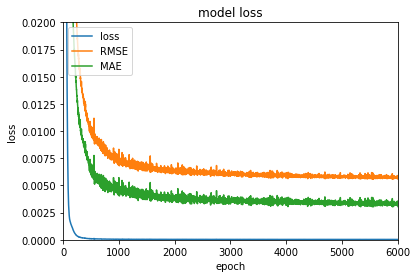

In [66]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['mae'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'RMSE','MAE'], loc='upper left')
axes = plt.gca()
axes.set_xlim([0,6000])
axes.set_ylim([0.0,0.02])
plt.show()

In [13]:
model.load_weights("newmodel/model_new4.ckpt")

In [67]:
model.evaluate(test_images,  test_Y, verbose=2)

1/1 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0546 - mae: 0.0396


[0.002975805662572384, 0.05455094203352928, 0.03964772820472717]

In [17]:
x = test_images[2].reshape((1,) + test_images[1].shape)
predicts = model.predict(test_images)

In [ ]:
print(predicts)

In [ ]:
predicts1 = scaler.inverse_transform(predicts)
print(predicts1)

[array([ -0.00012504,  -0.05377322, 734.4073    ], dtype=float32), array([  0.00032032,  -0.3723369 , 368.50665   ], dtype=float32), array([  0.00011858,  -0.09093527, 176.73213   ], dtype=float32), array([ -0.00010118,   0.22275902, 483.49536   ], dtype=float32)]


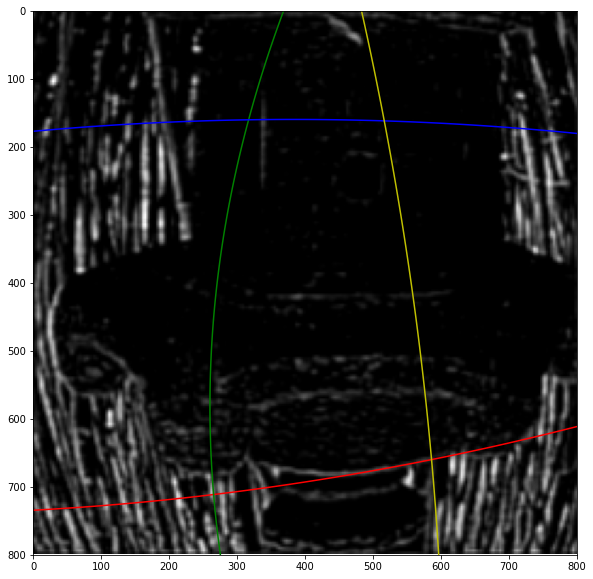

[array([ -0.00009109,   0.1387319 , 774.5908    ], dtype=float32), array([  0.00005933,  -0.09671997, 121.544586  ], dtype=float32), array([ 0.00005028,  0.11522587, 71.16786   ], dtype=float32), array([ -0.00021224,   0.05047294, 606.1953    ], dtype=float32)]


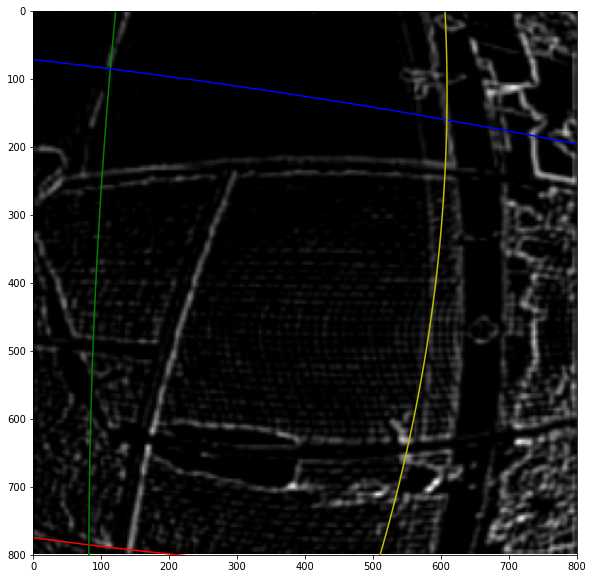

[array([ -0.00011159,   0.1642307 , 505.16132   ], dtype=float32), array([  0.00008396,  -0.12024979, 169.49956   ], dtype=float32), array([  0.00010346,  -0.06601948, 344.60593   ], dtype=float32), array([ -0.00008912,   0.05001931, 569.23834   ], dtype=float32)]


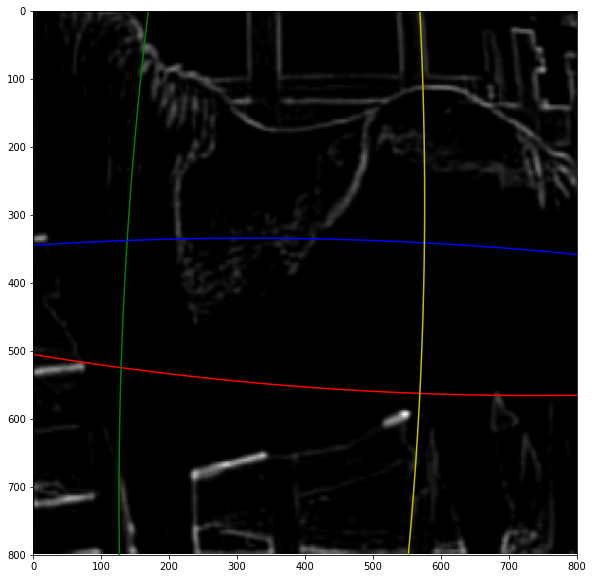

[array([ -0.00010832,   0.05641954, 513.70276   ], dtype=float32), array([  0.00022803,  -0.16265692, 136.93767   ], dtype=float32), array([  0.00013256,  -0.10116231, 153.33961   ], dtype=float32), array([ -0.00015816,   0.03651804, 834.9744    ], dtype=float32)]


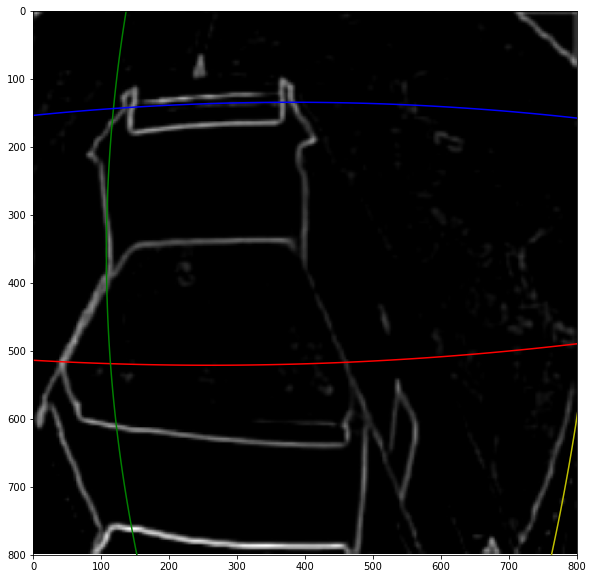

[array([ -0.00026332,   0.28627452, 744.4999    ], dtype=float32), array([ 0.00017422, -0.06421045,  9.861427  ], dtype=float32), array([  0.00018521,  -0.24151091, 140.77185   ], dtype=float32), array([ -0.00029197,   0.32715818, 605.48083   ], dtype=float32)]


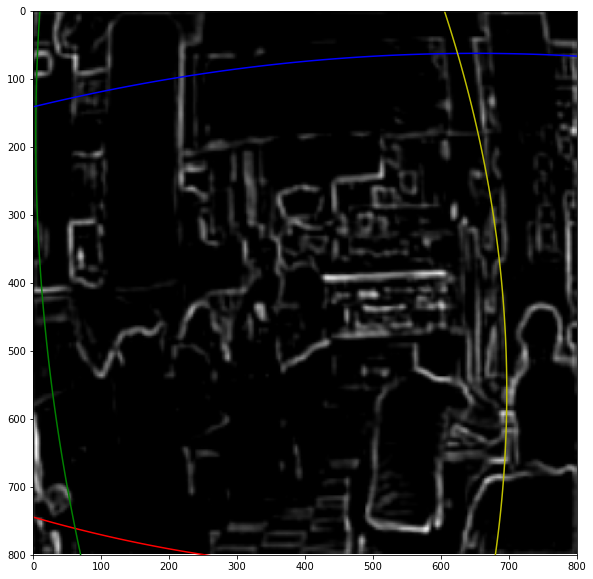

[array([ -0.00004121,   0.0638714 , 707.64453   ], dtype=float32), array([  0.0000978 ,  -0.06255628, 170.0218    ], dtype=float32), array([ 0.00008545, -0.10368211, 87.63746   ], dtype=float32), array([ -0.0001362 ,  -0.03161383, 700.70184   ], dtype=float32)]


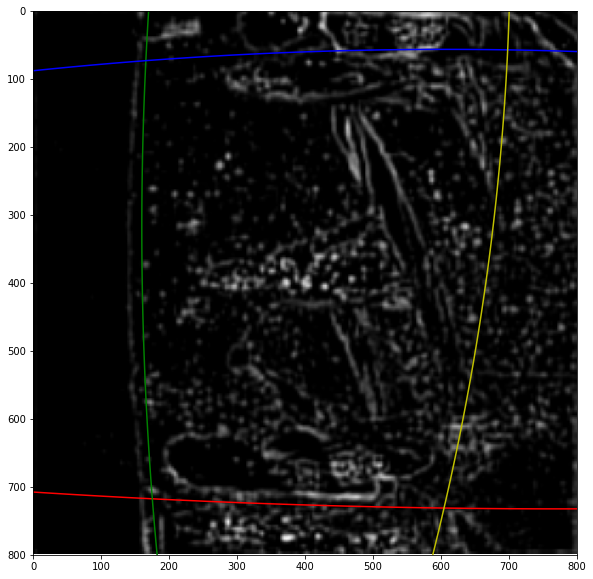

[array([ -0.00005659,   0.06096511, 712.80383   ], dtype=float32), array([  0.00022447,  -0.21111958, 139.80038   ], dtype=float32), array([  0.00008074,  -0.07151791, 150.88417   ], dtype=float32), array([ -0.000168  ,   0.15609337, 635.48193   ], dtype=float32)]


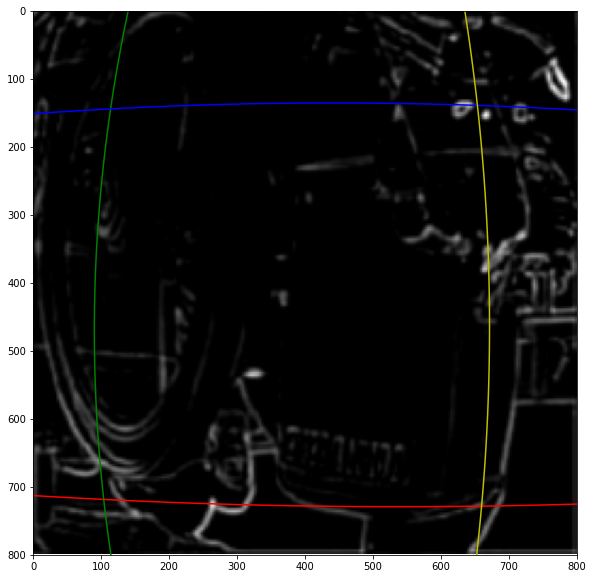

[array([ -0.00027914,   0.20856455, 690.42664   ], dtype=float32), array([  0.00013825,  -0.12981853, 178.03624   ], dtype=float32), array([ 0.00013565, -0.01748941, 88.556305  ], dtype=float32), array([ -0.00019715,   0.13098863, 609.97485   ], dtype=float32)]


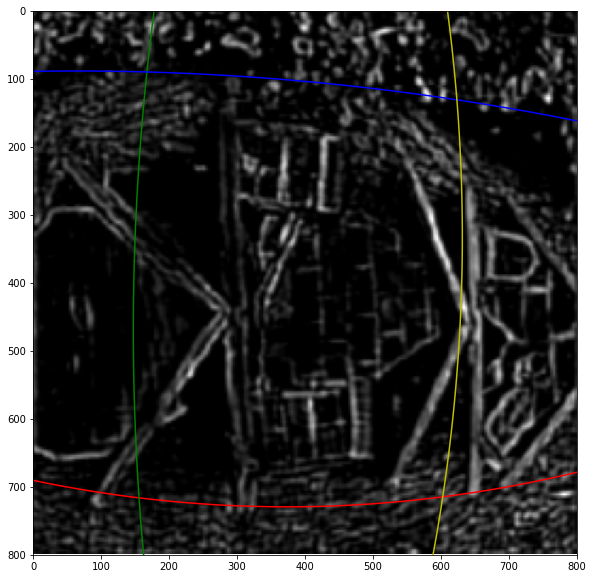

[array([ -0.00004148,   0.05713909, 689.86957   ], dtype=float32), array([-0.00002747,  0.03189355, 40.070816  ], dtype=float32), array([  0.00000625,   0.02998825, 167.8682    ], dtype=float32), array([ -0.00009532,   0.2034811 , 610.3194    ], dtype=float32)]


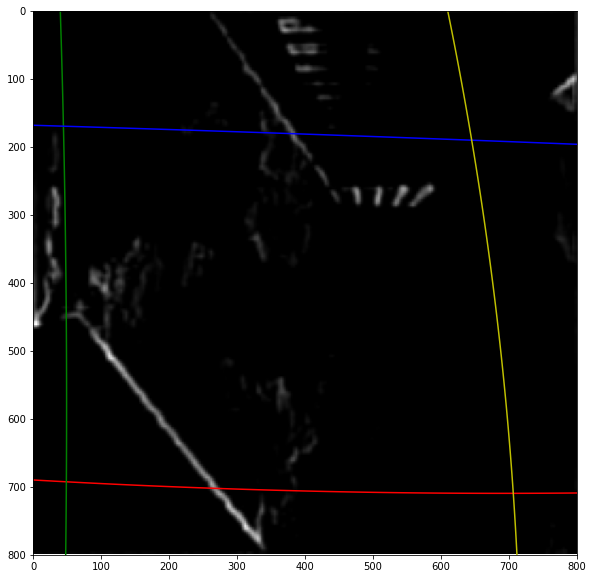

[array([ -0.00026335,   0.20175204, 660.0152    ], dtype=float32), array([  0.0001398,  -0.1623725, 155.91281  ], dtype=float32), array([  0.00006829,  -0.00039521, 130.02089   ], dtype=float32), array([ -0.00000369,   0.19062391, 537.2197    ], dtype=float32)]


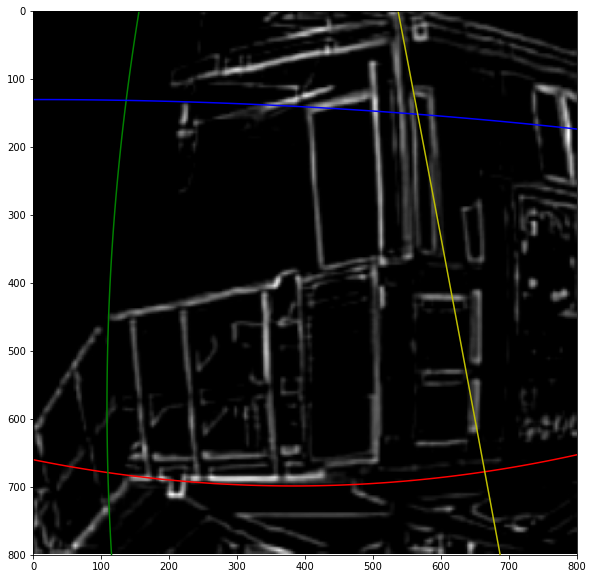

[array([  0.00008057,  -0.00872785, 629.32385   ], dtype=float32), array([  0.00021509,  -0.21830189, 284.90756   ], dtype=float32), array([  0.00013404,  -0.14049366, 134.62524   ], dtype=float32), array([ -0.00009708,  -0.09144858, 577.971     ], dtype=float32)]


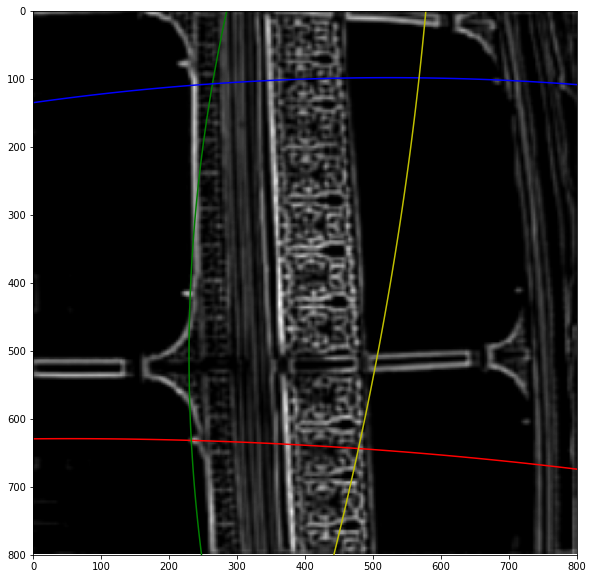

In [19]:
import matplotlib.pyplot as plt

for ii in range(len(test_images)):
    pr = []
    x = test_images[ii].reshape((1,) + test_images[ii].shape)
    predicts = model.predict(x)
    predicts1 = scaler.inverse_transform(predicts)
    for i in range(0,10,3):
      pr.append(predicts1[0][i:i+3])
    print(pr)
    tempImg = tf.image.resize(test_images[ii]*255, [800, 800]) 
    line = np.linspace(0,800,100)
    plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.set_xlim([0,800])
    axes.set_ylim([0,800])
    axes.invert_yaxis()
    plt.imshow(np.squeeze(tempImg),cmap="gray")
    c = ['r','g','b','y']
    for i in range(4):
      if i==0 or i==2:
        plt.plot(line,mdl(pr[i],line),c=c[i])
      else:
        plt.plot(mdl(pr[i],line),line,c=c[i])

    plt.show()

In [39]:
def drawGrid(y,y1,x):
    _y = []
    for i in range(100):
        _y.append(np.linspace(y[i],y1[i],10))
    _y = np.array(_y)

    for i in range(10):
        plt.plot(x,_y[:,i])

def drawGrid2(x,x1,y):
    _x = []
    for i in range(100):
        _x.append(np.linspace(x[i],x1[i],10))
    _x = np.array(_x)

    for i in range(10):
        plt.plot(_x[:,i],y)

[array([ -0.00014374,   0.12398911, 632.647     ], dtype=float32), array([  0.00008249,  -0.17770636, 203.51044   ], dtype=float32), array([ -0.0000815 ,   0.02671672, 375.22067   ], dtype=float32), array([ -0.0000625 ,  -0.07330577, 695.49945   ], dtype=float32)]


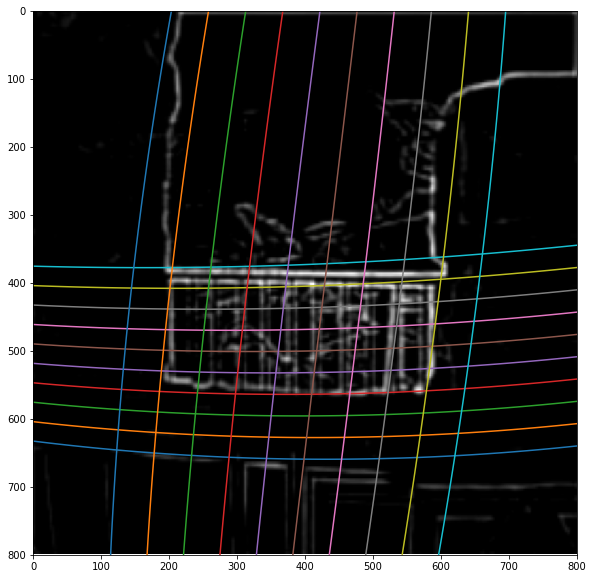

[array([ -0.00013347,   0.11397127, 692.71643   ], dtype=float32), array([  0.00000193,  -0.02588407, 144.07162   ], dtype=float32), array([ 0.00002611,  0.0005341 , 43.307487  ], dtype=float32), array([ -0.00004341,   0.00475504, 732.2614    ], dtype=float32)]


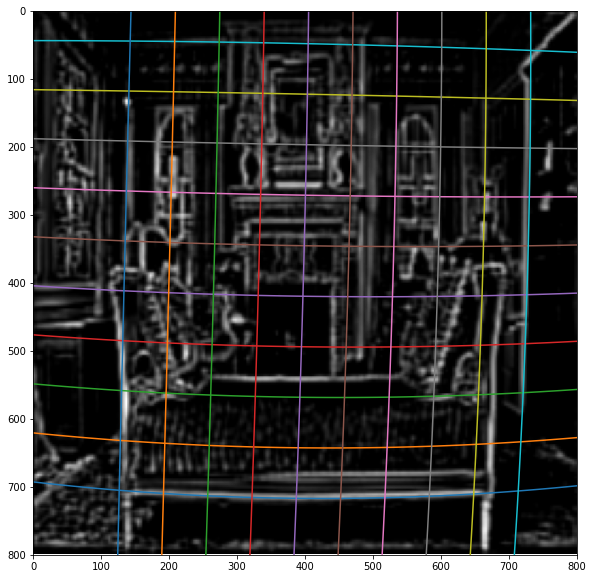

[array([ -0.00047914,   0.4140658 , 667.9703    ], dtype=float32), array([0.00002427, 0.04592746, 9.730523  ], dtype=float32), array([ 0.0000293 ,  0.01656502, 15.540605  ], dtype=float32), array([  0.00002701,  -0.00431471, 799.8035    ], dtype=float32)]


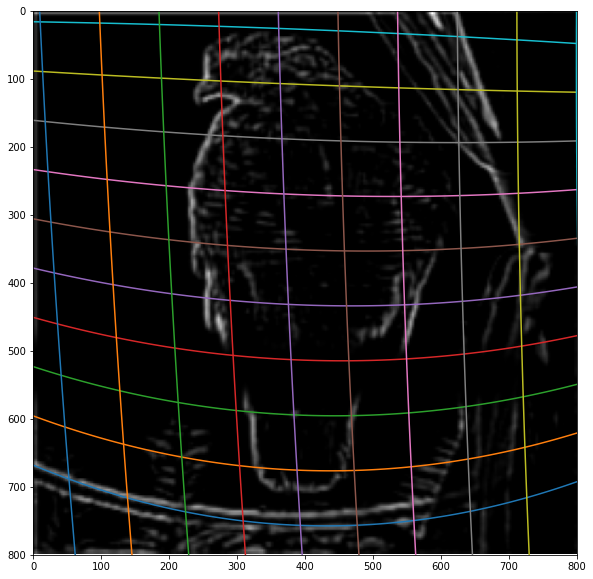

[array([  0.00006243,  -0.01009276, 477.66837   ], dtype=float32), array([-0.0000017 ,  0.11283841, 29.380089  ], dtype=float32), array([  0.00003405,   0.0200589 , 213.83629   ], dtype=float32), array([  0.00009098,   0.07867406, 582.5655    ], dtype=float32)]


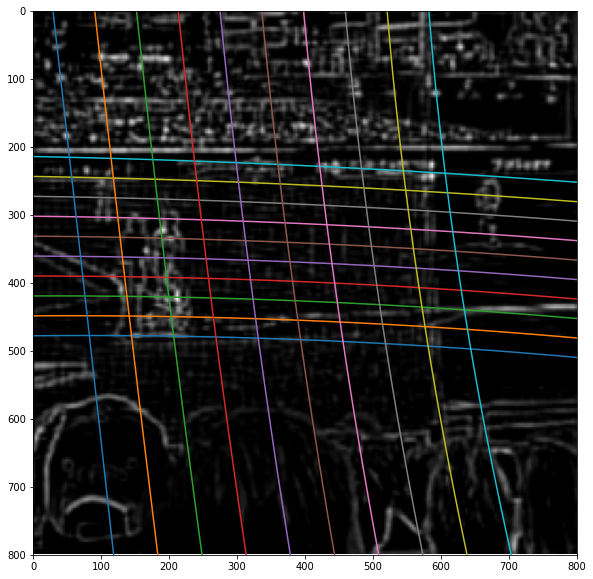

[array([ -0.00001038,   0.00491825, 728.57117   ], dtype=float32), array([ 0.00007928, -0.11169543, 96.72076   ], dtype=float32), array([  0.0000085 ,  -0.01328422, 132.06084   ], dtype=float32), array([ -0.00001146,  -0.03165163, 750.7515    ], dtype=float32)]


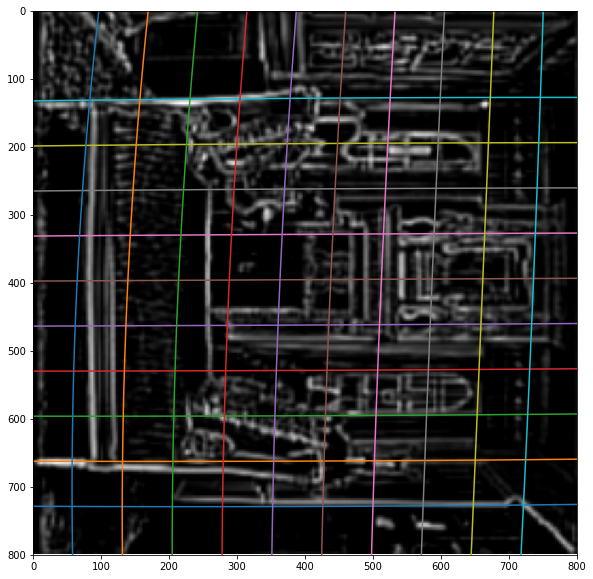

[array([  0.00004967,  -0.01609207, 558.4075    ], dtype=float32), array([ 0.0000232 ,  0.06143932, 17.980854  ], dtype=float32), array([ 0.00003621,  0.01420816, 21.319649  ], dtype=float32), array([  0.00003528,  -0.00192963, 786.7882    ], dtype=float32)]


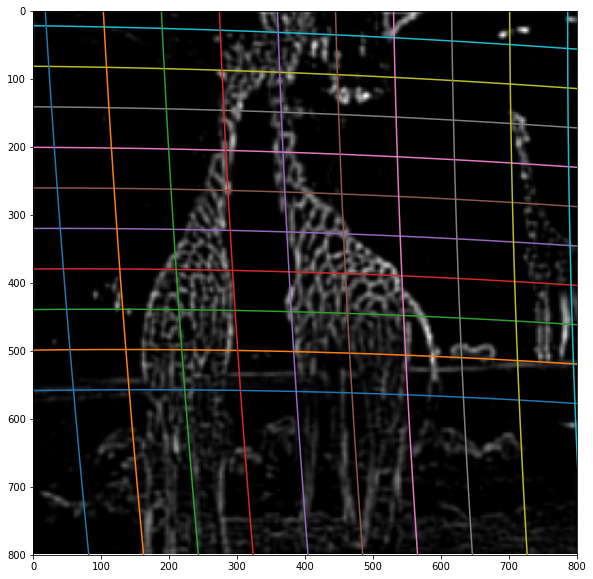

[array([ -0.00015506,   0.11976239, 472.2426    ], dtype=float32), array([ -0.00001995,   0.0055753 , 336.41287   ], dtype=float32), array([ -0.00001958,  -0.03763628, 173.76761   ], dtype=float32), array([  0.00003732,   0.0071614 , 567.22394   ], dtype=float32)]


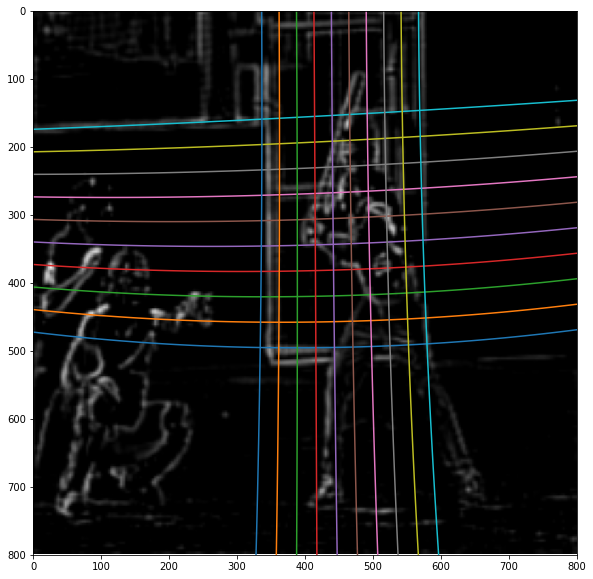

[array([  0.00001599,   0.03415792, 642.62994   ], dtype=float32), array([-0.00000012,  0.00417551, -8.14565   ], dtype=float32), array([  0.00007755,  -0.15223153, 224.39484   ], dtype=float32), array([ -0.00001422,  -0.00445975, 800.5964    ], dtype=float32)]


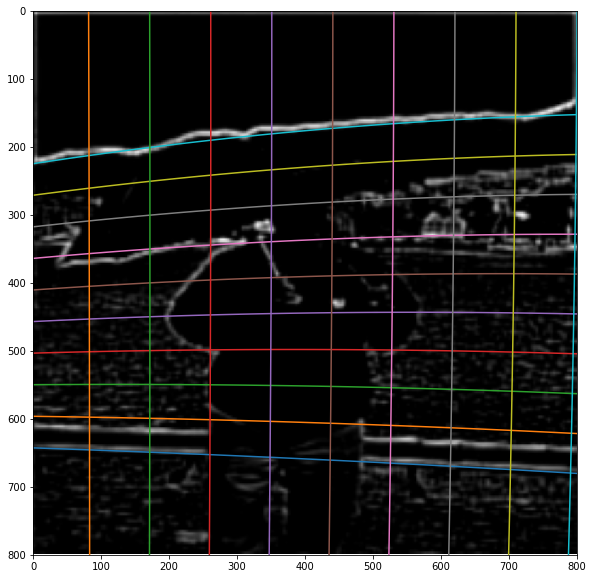

[array([ -0.00002181,   0.04526469, 491.28735   ], dtype=float32), array([ -0.00001357,   0.0237683 , 176.91351   ], dtype=float32), array([  0.000045,  -0.217827, 286.96713 ], dtype=float32), array([ -0.0000519,   0.1021518, 652.4334   ], dtype=float32)]


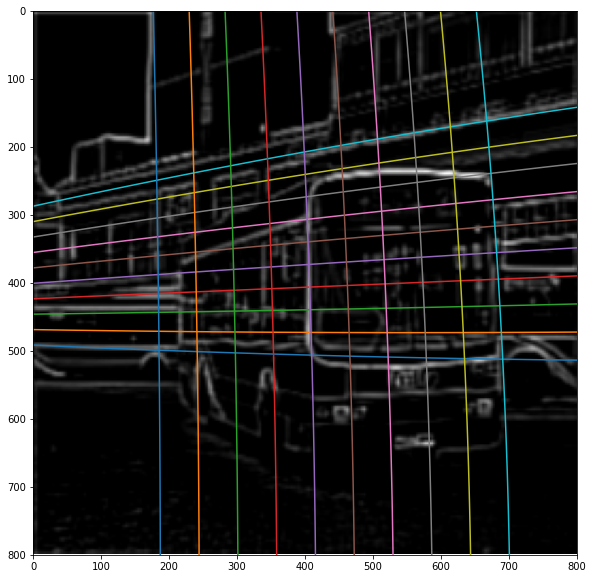

[array([  0.00001764,   0.05502155, 500.9386    ], dtype=float32), array([  0.00002156,  -0.08140817, 311.66296   ], dtype=float32), array([-0.0000327 , -0.00631748, 46.479576  ], dtype=float32), array([  0.00001069,  -0.05165956, 664.8994    ], dtype=float32)]


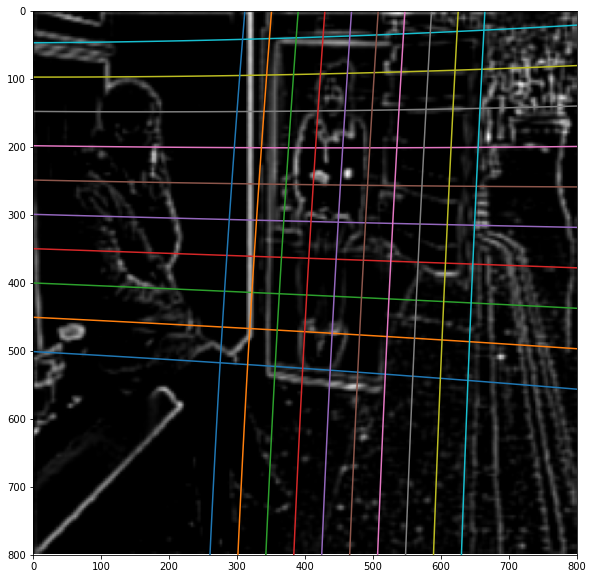

[array([ -0.00001226,   0.01961518, 508.45804   ], dtype=float32), array([  0.00006974,  -0.06217352, 196.35135   ], dtype=float32), array([  0.00009581,  -0.07183436, 130.52019   ], dtype=float32), array([ -0.00002284,   0.02687784, 696.8507    ], dtype=float32)]


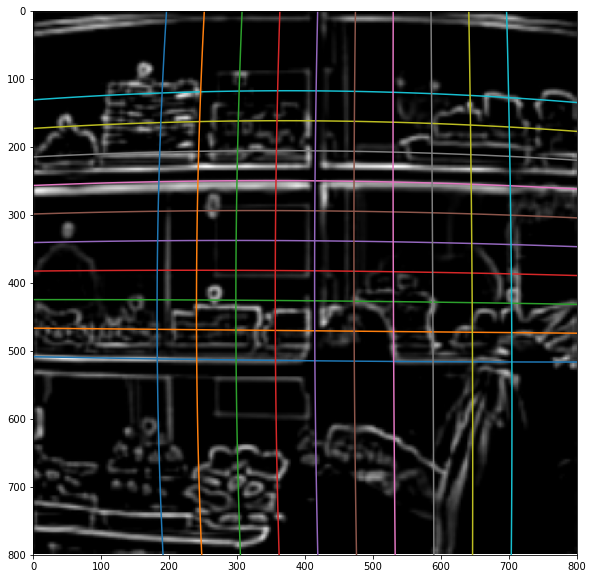

[array([ -0.00018795,   0.05644076, 592.15265   ], dtype=float32), array([  0.00028937,  -0.18238612, 163.82571   ], dtype=float32), array([  0.0002621 ,  -0.17608769, 187.5446    ], dtype=float32), array([ -0.00029845,   0.25996488, 628.7237    ], dtype=float32)]


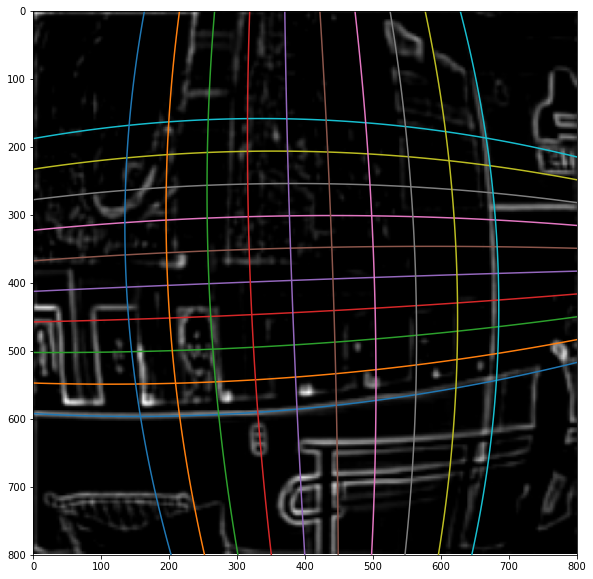

[array([ -0.0000056 ,  -0.06094721, 748.32806   ], dtype=float32), array([ 0.00002839, -0.00551873, 64.33279   ], dtype=float32), array([  0.00003618,  -0.07123883, 218.57146   ], dtype=float32), array([ -0.00013737,  -0.07054658, 761.0005    ], dtype=float32)]


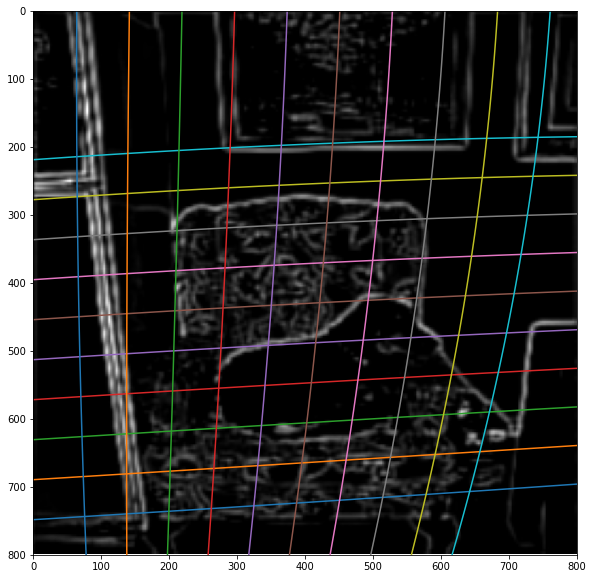

[array([ -0.00001829,  -0.04405262, 740.3929    ], dtype=float32), array([  0.00000969,  -0.1272985 , 177.849     ], dtype=float32), array([ -0.0000102 ,  -0.03164126, 261.80237   ], dtype=float32), array([ -0.00004746,  -0.04161783, 777.60284   ], dtype=float32)]


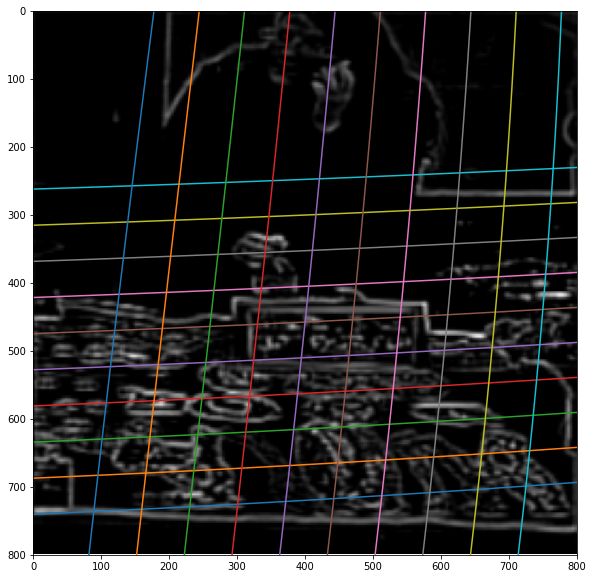

[array([  0.00152507,  -1.3196045 , 894.9648    ], dtype=float32), array([ -0.0000637 ,  -0.09174568, -28.193327  ], dtype=float32), array([ -0.00023164,   0.10704952, 349.37048   ], dtype=float32), array([ -0.00008657,  -0.00553278, 771.6167    ], dtype=float32)]


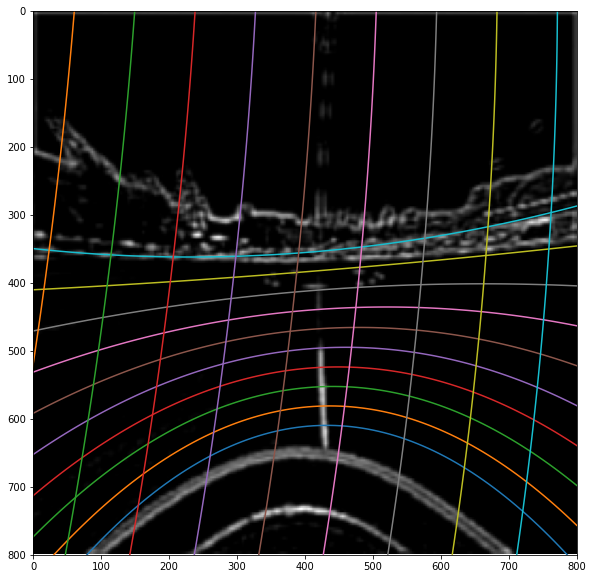

In [40]:
for ii in range(len(test_images)):
    pr = []
    x = test_images[ii].reshape((1,) + test_images[ii].shape)
    predicts = model.predict(x)
    predicts1 = scaler.inverse_transform(predicts)
    for i in range(0,10,3):
      pr.append(predicts1[0][i:i+3])
    print(pr)
    tempImg = tf.image.resize(test_images[ii]*255, [800, 800]) 
    line = np.linspace(0,800,100)
    plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.set_xlim([0,800])
    axes.set_ylim([0,800])
    axes.invert_yaxis()
    plt.imshow(np.squeeze(tempImg),cmap="gray")
    c = ['r','g','b','y']
    #plt.plot(line,mdl(pr[i],line),c=c[i])
    drawGrid(mdl(pr[0],line),mdl(pr[2],line), line)
    #plt.plot(mdl(pr[i],line),line,c=c[i])
    drawGrid2(mdl(pr[1],line),mdl(pr[3],line), line)

    plt.show()